In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.distributions as dist
import numpy as np
import argparse
import wandb
from sampler_galaxy import load_images_list, sampler_galaxy

from utils import RJSD_estimator

# autoload changes in the imported modules

%load_ext autoreload
%autoreload 2
%matplotlib inline


/home/keider/anaconda3/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (4.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


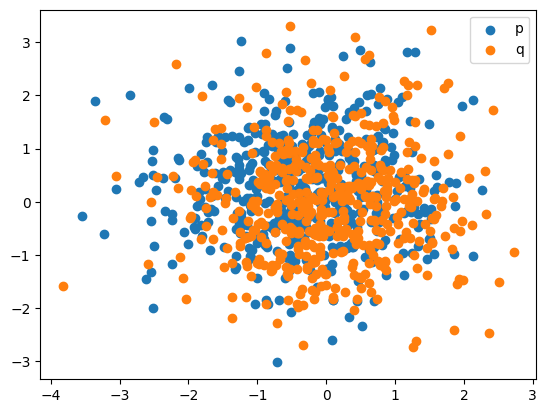

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette()
def finding_mu_p(kl_divergence, d):
    mu_p = torch.zeros(d)
    mu_p[0] = -np.sqrt(2*kl_divergence)
    mu_p[1] = np.sqrt(2*kl_divergence)
    return mu_p

# Create function to sample from two multivariate Gaussians with identity covariance matrices and different means
def sample_gaussians(mu_p, d, n):
    p = torch.distributions.MultivariateNormal(mu_p, torch.eye(d))
    q = torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
    samples_p = p.sample((n,))
    samples_q = q.sample((n,))
    return samples_p, samples_q

# example usage

d = 2
n = 500
kl_divergence = 0.03
mu_p = finding_mu_p(kl_divergence, d)
X, Y = sample_gaussians(mu_p, d, n)

# plot the samples

plt.scatter(X[:, 0], X[:, 1], color=colors[0], label='p')
plt.scatter(Y[:, 0], Y[:, 1], color=colors[1], label='q')
plt.legend()
plt.show()

In [50]:
# use cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
p_order_approx = [1,2,3,4,5,6,7,8,9,10]
sigma = 0.5
permutations = 100
repetitions = 50
D_js_p = np.zeros((len(p_order_approx), permutations))
D_js = np.zeros((len(p_order_approx), repetitions))
relative_difference = np.zeros((len(p_order_approx),repetitions))

for k in range(repetitions):
    X, Y = sample_gaussians(mu_p, d, n)
    X = X.to(device)
    Y = Y.to(device)
    X_train, X_test = X[:len(X)//2], X[len(X)//2:]
    Y_train, Y_test = Y[:len(Y) // 2], Y[len(Y) // 2:]
    for j,p in enumerate(p_order_approx):

        RJSD_est = RJSD_estimator(isotropic = True, order_approx=p, sigma= sigma)
        RJSD_est.fit(X_train, Y_train, epochs = 200, lr = 0.05, verbose=False)

        D_js[j,k] = RJSD_est.forward(X_test, Y_test)
        for i in range(permutations):
            n1 = len(X_test)
            Z_test = torch.cat((X_test,Y_test), dim = 0)
            Z_perm = Z_test[torch.randperm(Z_test.shape[0])]
            X_p = Z_perm[:n1].detach()
            Y_p = Z_perm[n1:].detach()
            D_js_p[j,i] = RJSD_est.forward(X_p, Y_p)
        relative_difference[j,k] = (D_js[j,k] - np.mean(D_js_p[j]))/np.std(D_js_p[j])

/tmp/ipykernel_658288/2203024780.py:30: RuntimeWarning: invalid value encountered in scalar divide
  relative_difference[j,k] = (D_js[j,k] - np.mean(D_js_p[j]))/np.std(D_js_p[j])


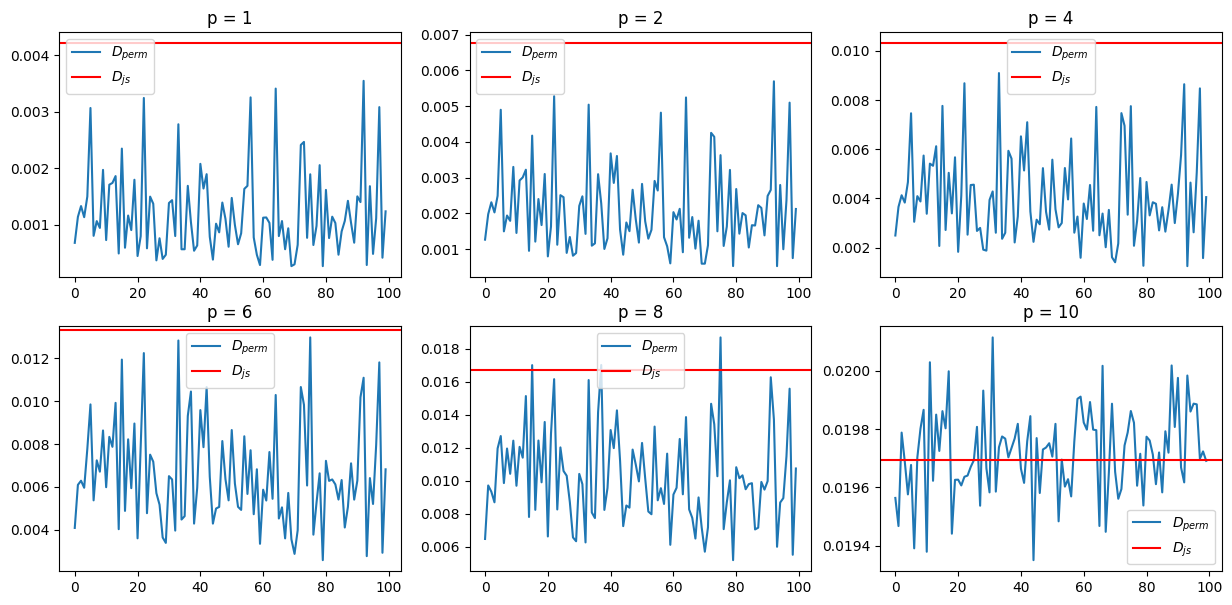

In [15]:
# make 6 different plots with the results per order of approximation with D_js as a horizontal line and the permutations for comparison
# 6 sibfigures
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
axs = axs.ravel()
for j,p in enumerate(p_order_approx):
    axs[j].plot(D_js_p[j, :], label=r'$D_{perm}$')
    axs[j].axhline(y=D_js[j], color='r', linestyle='-', label=r'$D_{js}$')
    axs[j].set_title(f'p = {p}')
    axs[j].legend()

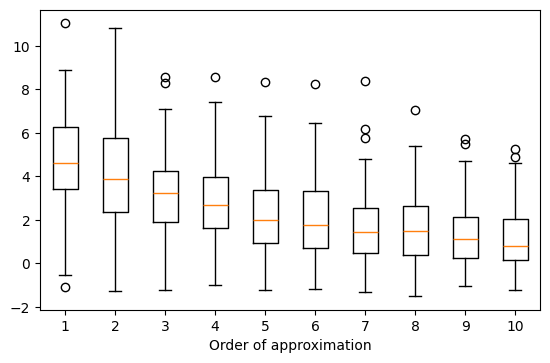

In [65]:

for i in range(len(p_order_approx)):
    #replace nans by median
    relative_difference[i, np.isnan(relative_difference[i])] = np.nanmedian(relative_difference[i])
fig = plt.figure(figsize =(5, 3))
ax = fig.add_axes([0, 0, 1, 1]) 
# Creating plot
bp = ax.boxplot(np.transpose(relative_difference))
ax.set_xticklabels(p_order_approx)
plt.xlabel('Order of approximation')
plt.title('Gaussian Mixture')
plt.show()

In [66]:
from utils import sampler_mixture
# Do the same with the Galaxy dataset
# use cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
p_order_approx = [1,2,3,4,5,6,7,8,9,10]
sigma = 2.0
permutations = 100
repetitions = 50
D_js_p = np.zeros((len(p_order_approx), permutations))
D_js = np.zeros((len(p_order_approx), repetitions))
relative_difference = np.zeros((len(p_order_approx),repetitions))
sample_size = 2000
shift = 1.3
for k in range(repetitions):
    seed = k
    X, Y = sampler_mixture(seed = seed, m=sample_size, n=sample_size, d=2, mu=20, std_1=1, std_2=shift)
    X = X.to(device)
    Y = Y.to(device)
    X_train, X_test = X[:len(X)//2], X[len(X)//2:]
    Y_train, Y_test = Y[:len(Y) // 2], Y[len(Y) // 2:]
    for j,p in enumerate(p_order_approx):

        RJSD_est = RJSD_estimator(isotropic = True, order_approx=p, sigma= sigma)
        RJSD_est.fit(X_train, Y_train, epochs = 200, lr = 0.05, verbose=False)

        D_js[j,k] = RJSD_est.forward(X_test, Y_test)
        for i in range(permutations):
            n1 = len(X_test)
            Z_test = torch.cat((X_test,Y_test), dim = 0)
            Z_perm = Z_test[torch.randperm(Z_test.shape[0])]
            X_p = Z_perm[:n1].detach()
            Y_p = Z_perm[n1:].detach()
            D_js_p[j,i] = RJSD_est.forward(X_p, Y_p)
        relative_difference[j,k] = (D_js[j,k] - np.nanmean(D_js_p[j]))/np.nanstd(D_js_p[j])

/tmp/ipykernel_658288/2680984169.py:34: RuntimeWarning: invalid value encountered in scalar divide
  relative_difference[j,k] = (D_js[j,k] - np.nanmean(D_js_p[j]))/np.nanstd(D_js_p[j])


(-1.0, 4.0)

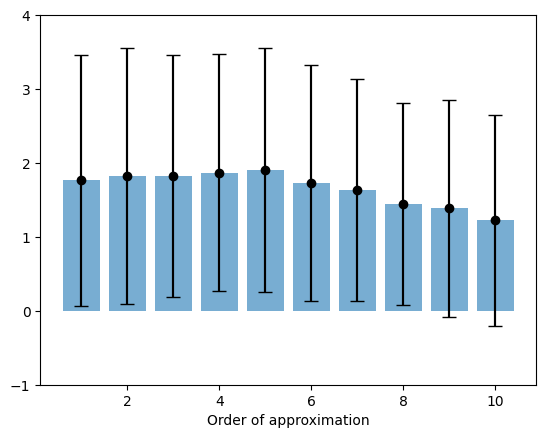

In [75]:
yerr = np.nanstd(relative_difference, axis=1)
mean_values = np.nanmean(relative_difference, axis=1)
plt.bar(p_order_approx, mean_values, capsize=5, alpha=0.6)
plt.xlabel('Order of approximation')
# ylim
plt.ylim(-1, 4)

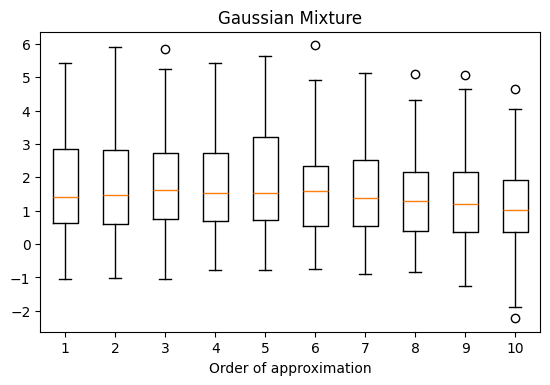

In [76]:

for i in range(len(p_order_approx)):
    #replace nans by median
    relative_difference[i, np.isnan(relative_difference[i])] = np.nanmedian(relative_difference[i])
fig = plt.figure(figsize =(5, 3))
ax = fig.add_axes([0, 0, 1, 1]) 
# Creating plot
bp = ax.boxplot(np.transpose(relative_difference))
ax.set_xticklabels(p_order_approx)
plt.xlabel('Order of approximation')
plt.title('Gaussian Mixture')
plt.show()


In [44]:
relative_difference.shape

(10, 10)

In [79]:
# Do the same with the Galaxy dataset
# use cuda
images_list = load_images_list(highres=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
p_order_approx = [1,2,3,4,5,6,7,8,9,10]
permutations = 100
repetitions = 50
D_js_p = np.zeros((len(p_order_approx), permutations))
D_js = np.zeros((len(p_order_approx), repetitions))
relative_difference = np.zeros((len(p_order_approx),repetitions))
sample_size = 1000
corruption = 0.15
for k in range(repetitions):
    seed = k
    X, Y = sampler_galaxy(key = seed, m=sample_size, n=sample_size, corruption = corruption,images_list=images_list)
    X = X.to(device)
    Y = Y.to(device)
    X_train, X_test = X[:len(X)//2], X[len(X)//2:]
    Y_train, Y_test = Y[:len(Y) // 2], Y[len(Y) // 2:]
    for j,p in enumerate(p_order_approx):

        RJSD_est = RJSD_estimator(isotropic = False, order_approx=p, sigma = 12288.0, sigma0=25.0, epsilon = 0.6, deep = True, is_image=True)
        RJSD_est.fit(X_train, Y_train, epochs = 100, lr = 0.00008, verbose=False)
        D_js[j,k] = RJSD_est.forward(X_test, Y_test)
        for i in range(permutations):
            n1 = len(X_test)
            Z_test = torch.cat((X_test,Y_test), dim = 0)
            Z_perm = Z_test[torch.randperm(Z_test.shape[0])]
            X_p = Z_perm[:n1].detach()
            Y_p = Z_perm[n1:].detach()
            D_js_p[j,i] = RJSD_est.forward(X_p, Y_p)
        relative_difference[j,k] = (D_js[j,k] - np.nanmean(D_js_p[j]))/np.nanstd(D_js_p[j])

/home/keider/.local/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


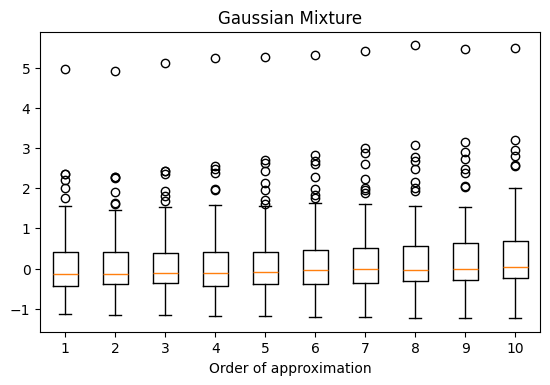

In [80]:

for i in range(len(p_order_approx)):
    #replace nans by median
    relative_difference[i, np.isnan(relative_difference[i])] = np.nanmedian(relative_difference[i])
fig = plt.figure(figsize =(5, 3))
ax = fig.add_axes([0, 0, 1, 1]) 
# Creating plot
bp = ax.boxplot(np.transpose(relative_difference))
ax.set_xticklabels(p_order_approx)
plt.xlabel('Order of approximation')
plt.title('Gaussian Mixture')
plt.show()


Text(0.5, 1.0, 'Galaxy dataset')

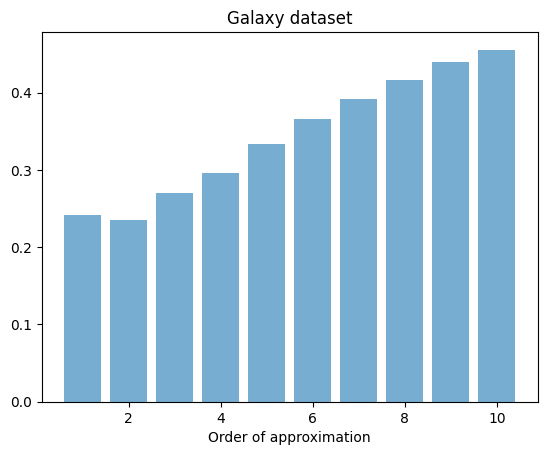

In [85]:
yerr = np.nanstd(relative_difference, axis=1)
mean_values = np.nanmean(relative_difference, axis=1)
plt.bar(p_order_approx, mean_values, capsize=5, alpha=0.6)
# plt.errorbar(p_order_approx, mean_values, yerr=yerr, fmt='o', color='k')
plt.xlabel('Order of approximation')
plt.title('Galaxy dataset')
# ylim
# plt.ylim(-1, 4)